* Tides impact in the river channel

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import StraTimeSeries as sts
import DetermineEdgePlume as DEP
import R_mixStuff as RS
from R_mixStuff import sites
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
%matplotlib inline

In [2]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 

In [3]:
## load grid_T model results
octriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc')
mayriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_T.nc')
janriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_T.nc')

octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc')
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc')

octnowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
maynowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_T.nc')
jannowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_T.nc')

octnotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_T.nc')
maynotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015notides/may2015notides_T.nc')
jannotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016notides/jan2016notides_T.nc')

In [10]:
## load grid_U model results to find peak ebbs at river mouth
octall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
mayall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_U.nc')
janall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_U.nc')

In [48]:
def get_Rmix(gridT1,gridT2,gridT3,gridT4,gridT5,tst,ted,dep_ind,indices,ave=False):
    """This function was made to get the time averaged Rmix"""
    rmix = {};
    for grid_T,st,in zip([gridT1,gridT2,gridT3,gridT4,gridT5],['onlyriver','river+tides',\
                        'river+winds','nof','all']):
        S = grid_T.variables['vosaline']
        lon = grid_T.variables['nav_lon']
        dep = grid_T.variables['deptht']
        if ave== True:
            S_ave = np.nanmean(S[tst:ted+1],axis = 0)
        else:
            S_ave = np.nanmean(S[indices[:]],axis = 0)
        rmix[st] = RS.R_mixAve(S_ave,np_mask,dep_ind)
    return rmix

In [5]:
def salinity_profile_update(S,tst,ted,dep_ind,np_mask,string,rmin = 0,rmax =1.0 ):
    """This function was to plot salinity transect and Rmix mainly in the river for 
    winds, tides, and all cases that should be selected"""
    fig = plt.figure(figsize=(8, 6))
    G = gridspec.GridSpec(2, 1) 
    G.update(hspace=0., wspace=0.3)
    axes_1 =fig.add_subplot(G[0,0]) ## rmix
    axes_2 = fig.add_subplot(G[1,0],sharex=axes_1) ## salinity profile
    plt.setp(axes_1.get_xticklabels(), visible=False)
    S_small = {};

    S = grid_T.variables['vosaline']
    S_small[string] =np.ma.masked_array(np.nanmean(S[tst:ted+1,:,36,70:123],axis=0),mask =np_mask[:,36,70:123])
    dep = grid_T.variables['deptht']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    mesh = axes_2.contourf(lon[36,70:123],dep[:],S_small[string][:],np.arange(0,34,1),cmap='jet')
    axes_2.set_ylim([dep[-20],dep[0]])
    axes_2.set_xlim([lon[36,70],lon[36,123]])
    
    
    r_mix = get_Rmix(grid_T,grid_T,grid_T,grid_T,grid_T,tst,ted,dep_ind)
    axes_1.plot(lon[36,70:123],r_mix[string][36,70:123],'r-*')
    axes_1.set_ylim([rmin,rmax])
    axes_1.set_title(string)
    return r_mix, S_ave

(48.95, 49.4)

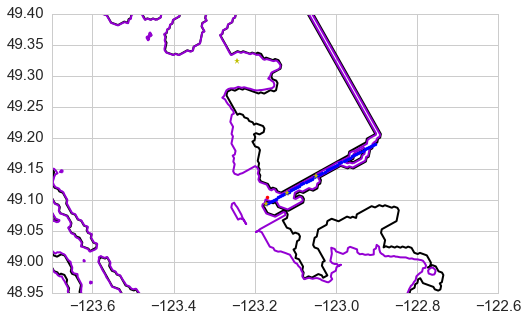

In [8]:
fig, ax = plt.subplots(1,1,figsize = (8,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
lon = octall_T.variables['nav_lon']
lat = octall_T.variables['nav_lat']
ax.plot(lon[36,70:123],lat[36,70:123],'b.')
ax.plot(lon[36,94],lat[36,94],'y*')
ax.plot(lon[36,70],lat[36,70],'y*')
ax.plot(lon[36,80],lat[36,80],'y*')
ax.plot(lon[38,72],lat[38,72],'r.') ## grid cell that peak ebb based on
ax.plot(lon[466-380,329-240],lat[466-380,329-240],'y*')
ax.set_xlim([-123.7,-122.6])
ax.set_ylim([48.95,49.4])

# Method 1. average all the peak ebb times

* Oct

In [18]:
U = {}
for month,gridU in zip(['jan','oct','may'],[janall_U,octall_U,mayall_U]):
    U[month] = gridU.variables['vozocrtx']

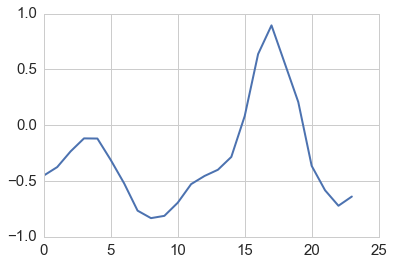

In [30]:
plt.plot(U['oct'][:24,0,38,72])


PEC = {} ## short form of peak ebb currents!
PET = {}## short form of peak ebb times!
for month in ['jan','oct','may']:
    PEC[month] = [];
    PET[month] = [];
    
for month in ['jan','oct','may']:
    for t in np.arange(0,len(U[month]),24):
        pec = np.nanmin(U[month][t:t+24,0,38,72])
        PEC[month].append(pec)
        pet = np.nanargmin(U[month][t:t+24,0,38,72])+t
        PET[month].append(pet)

In [88]:
def RmixSalinity(axes_1,axes_2,grid_T,string,tst,ted,dep_ind,indices,rmin = 0, rmax = 1,ave=True):
    
    plt.setp(axes_1.get_xticklabels(), visible=False)
    S_small = {};

    S = grid_T.variables['vosaline']
    S_small[string] = np.ma.masked_array(np.nanmean(S[PET['oct'][:],:,36,70:123],axis = 0),mask =np_mask[:,36,70:123])
    
    dep = grid_T.variables['deptht']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    mesh = axes_2.contourf(lon[36,70:123],dep[:],S_small[string][:],np.arange(0,34,1),cmap='jet')
    CS = axes_2.contour(lon[36,70:123],dep[:],S_small[string][:],[12])
    axes_2.set_ylim([dep[-20],dep[0]])
    axes_2.set_xlim([lon[36,70],lon[36,123]])
    axes_2.set_ylabel('Depth [m]')
    axes_2.set_xlabel('Longitude')
    
    r_mix = get_Rmix(grid_T,grid_T,grid_T,grid_T,grid_T,tst,ted,dep_ind,indices,ave=True)
    axes_1.plot(lon[36,70:123],r_mix[string][36,70:123],'r-*')
    axes_1.set_ylim([rmin,rmax])
    axes_1.set_ylabel('Rmix')
    return axes_1,axes_2

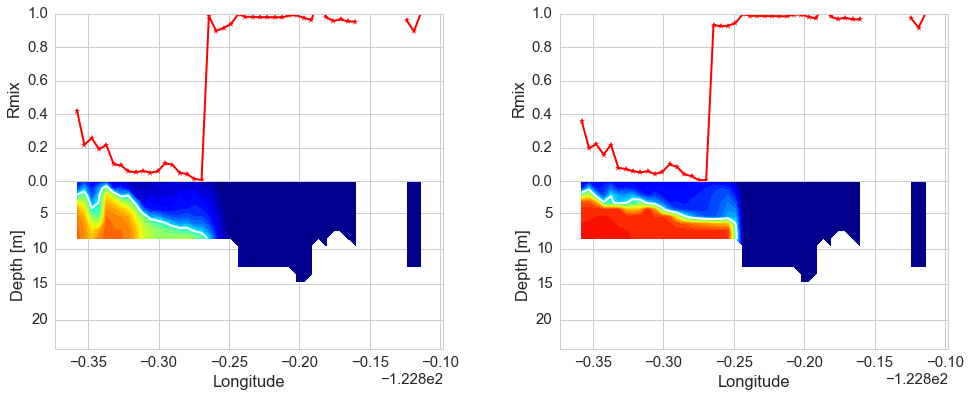

In [90]:
fig = plt.figure(figsize=(16, 6))
G = gridspec.GridSpec(2, 2) 
G.update(hspace=0, wspace=0.3)
for i,grid_T,string in zip(np.arange(2),[octall_T,octriver_T],['all','onlyriver']):
    axes_1 =fig.add_subplot(G[0,i]) ## rmix
    axes_2 = fig.add_subplot(G[1,i],sharex=axes_1) ## salinity profile
    axes_1,axes_2 = RmixSalinity(axes_1,axes_2,grid_T,string,tst,ted,dep_ind,PET['oct'],rmin = 0, rmax = 1,ave=True)

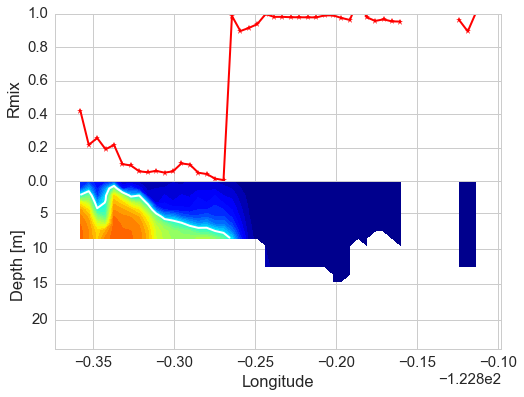

In [87]:
    grid_T = octall_T;string = 'all';rmin =0;rmax = 1; tst = 0;ted = 0;dep_ind = 10
    fig = plt.figure(figsize=(8, 6))
    G = gridspec.GridSpec(2, 1) 
    G.update(hspace=0, wspace=0.3)
    axes_1 =fig.add_subplot(G[0,0]) ## rmix
    axes_2 = fig.add_subplot(G[1,0],sharex=axes_1) ## salinity profile
    
    plt.setp(axes_1.get_xticklabels(), visible=False)
    S_small = {};

    S = grid_T.variables['vosaline']
    S_small[string] = np.ma.masked_array(np.nanmean(S[PET['oct'][:],:,36,70:123],axis = 0),mask =np_mask[:,36,70:123])
    
    dep = grid_T.variables['deptht']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    mesh = axes_2.contourf(lon[36,70:123],dep[:],S_small[string][:],np.arange(0,34,1),cmap='jet')
    axes_2.contour(lon[36,70:123],dep[:],S_small[string][:],[12])
    axes_2.set_ylim([dep[-20],dep[0]])
    axes_2.set_xlim([lon[36,70],lon[36,123]])
    axes_2.set_ylabel('Depth [m]')
    axes_2.set_xlabel('Longitude')
    
    r_mix = get_Rmix(grid_T,grid_T,grid_T,grid_T,grid_T,tst,ted,dep_ind,PET['oct'],ave=True)
    axes_1.plot(lon[36,70:123],r_mix[string][36,70:123],'r-*')
    axes_1.set_ylim([rmin,rmax])
    axes_1.set_ylabel('Rmix')

In [40]:
a[0,5]

3.8249884

In [43]:
(S[8,0,36,75]+S[34,0,36,75])/2

3.8249883651733398

In [31]:
PET['oct']

[8,
 34,
 58,
 83,
 97,
 134,
 159,
 171,
 196,
 220,
 245,
 269,
 294,
 319,
 344,
 370,
 395,
 420,
 432,
 457,
 481,
 506,
 544,
 555,
 579,
 604,
 629,
 653,
 679,
 703,
 742]

In [28]:
PEC['oct'][0]

-0.83274788

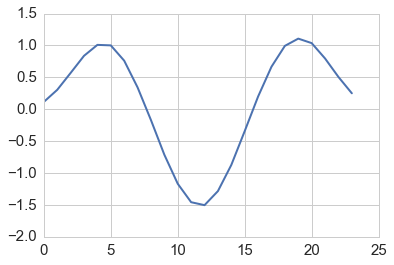

In [17]:
ssh = octall_T.variables['sossheig']
plt.plot(ssh[:24,38,72])